# DINOv2
Foundation model from META, a Visual Transformer (ViT) pre-trained on a high-quality corpus.
Smaller models distilled from the large model are available

In [2]:
#@formatter:off
%load_ext autoreload
%autoreload 2
#@formatter:on

## Prepare model

There are two options to load the model:
**Load model with weights from PyTorch hub** - does not work for CPU, because the model uses attention layer with CUDA-only implementation
**Use the model from this repo, with externally downloaded weights** - works after a few tweaks
  - in vision_transformer.py, change the attention layer to ordinary Attention
  - remove `.cuda()` in `setup.py`
Load only the desired model in the cells below

In [3]:
import torch
torch.device("cuda")

device(type='cuda')

In [5]:
# BASE
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')

Using cache found in /home/yilong/.cache/torch/hub/facebookresearch_dinov2_main
/home/yilong/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/yilong/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/yilong/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [6]:
# LARGE
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')

Using cache found in /home/yilong/.cache/torch/hub/facebookresearch_dinov2_main
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /home/yilong/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth
100%|██████████| 1.13G/1.13G [02:08<00:00, 9.49MB/s]


In [4]:
# GIANT
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')

Using cache found in /home/yilong/.cache/torch/hub/facebookresearch_dinov2_main
/home/yilong/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/yilong/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/yilong/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


## Try it out

Load a set of training images

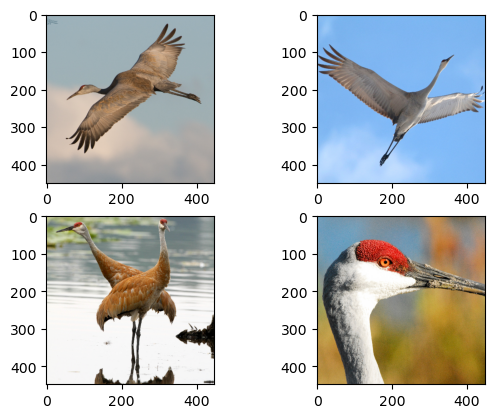

In [5]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import torchvision.transforms as tt

images = []

for i in range(1,5):
    image = cv2.imread(f"./data/crane/crane{i}.jpg");
    image = cv2.resize(image, (448,448))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype('float32')/255
    images.append(image)
    plt.subplot(220+i)
    plt.imshow(image)

# We need to reorder the images to [batch, channel, widht, height]
# The array of loaded images is [batch, height, width, channel]
images_arr = np.stack(images)
input_tensor = torch.Tensor(np.transpose(images_arr, [0, 3, 2, 1]))

transform = tt.Compose([tt.Normalize(mean=0.5, std=0.2)])

input_tensor = transform(input_tensor)

Pass the images through the DINOv2 model, and grab the outputs

We can use either the normalized patch tokens, or the full pre-normalized output, they give very similar results

In [6]:
result = model.forward_features(input_tensor)

: 

In [ ]:
patch_tokens = result['x_norm_patchtokens'].detach().numpy().reshape([4,1024,-1])

# patch_tokens = result['x_prenorm'].detach().numpy().reshape([4,1025,-1])
# patch_tokens = patch_tokens[:,1:,:]

Then, we can build a linear model over the patch tokens. We can segment the foreground object by building a simple linear classifier over the patch tokens: we compute the first component of the PCA and scale and threshold the output.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale

fg_pca = PCA(n_components=1)

masks=[]
plt.figure(figsize=(10,10))

all_patches = patch_tokens.reshape([-1,1024])
reduced_patches = fg_pca.fit_transform(all_patches)
# scale the feature to (0,1)
norm_patches = minmax_scale(reduced_patches)

# reshape the feature value to the original image size
image_norm_patches = norm_patches.reshape([4,1024])

for i in range(4):
    image_patches = image_norm_patches[i,:]

    # choose a threshold to segment the foreground
    mask = (image_patches > 0.6).ravel()
    masks.append(mask)

    image_patches[np.logical_not(mask)] = 0

    plt.subplot(221+i)
    plt.imshow(images[i])
    plt.imshow(image_patches.reshape([32,-1]).T, extent=(0,448,448,0), alpha=0.5)


Then we can further use a linear model to describe the foreground object. We compute the firs 3 components of PCA of the foreground patches, and visualize the features as RGB colors.

In [ ]:
object_pca = PCA(n_components=3)

# extract foreground patches
mask_indices = [0, *np.cumsum([np.sum(m) for m in masks]), -1]
fg_patches = np.vstack([patch_tokens[i,masks[i],:] for i in range(4)])

# fit PCA to foreground, scale each feature to (0,1)
reduced_patches = object_pca.fit_transform(fg_patches)
reduced_patches = minmax_scale(reduced_patches)

print(object_pca.explained_variance_ratio_)

# reshape the features to the original image size
plt.figure(figsize=(10,20))
for i in range(4):
    patch_image = np.zeros((1024,3), dtype='float32')
    patch_image[masks[i],:] = reduced_patches[mask_indices[i]:mask_indices[i+1],:]

    color_patches = patch_image.reshape([32,-1,3]).transpose([1,0,2])

    plt.subplot(421+(2*i))
    plt.imshow(color_patches)
    plt.subplot(421+(2*i)+1)
    plt.imshow(images[i])

for i in range(4):
    plt.subplot(425+i)
    plt.imshow

## Test

We try the PCA features on an unknown image of another crane.

In [ ]:
test_image = cv2.imread(f"./data/crane/crane_test.jpg");
test_image = cv2.resize(test_image, (672,672))  # unicorn: 224,280
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image = test_image.astype('float32')/255

plt.imshow(test_image)

test_images = [test_image]

test_images_arr = np.stack(test_images)
test_tensor = torch.Tensor(np.transpose(test_images_arr, [0, 3, 2, 1]))
test_tensor = transform(test_tensor)

In [ ]:
test_result = model.forward_features(test_tensor)

In [ ]:
test_patch_tokens = test_result['x_norm_patchtokens'].detach().numpy().reshape([2304, -1])
fg_result = fg_pca.transform(test_patch_tokens)
fg_result = minmax_scale(fg_result)

fg_mask = (fg_result > 0.5)

object_result = object_pca.transform(test_patch_tokens)
object_result = minmax_scale(object_result)

only_object = np.zeros_like(object_result)
only_object[fg_mask.ravel(), :] = object_result[fg_mask.ravel(), :]

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(test_image)
plt.subplot(122)
plt.imshow(only_object.reshape([48, -1, 3]).transpose([1, 0, 2]))

These results are very impressive, the model generalized from 4 images with only a linear model built on top.
The results may be biased because we used readily available images from the internet/wikipedia, that were probably part of the pre-training. We should test it with some custom images later.